In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.10.1
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.3
numpy 1.23.2
pandas 1.5.1
sklearn 1.1.3
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [2]:
train_dir = "./input/corn_leaf/train"
valid_dir = "./input/corn_leaf/valid"
test_dir = "./input/corn_leaf/test"
label_file = "./input/corn_leaf/corn_leaf_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))



True
True
True
['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']
['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']


In [3]:
labels = pd.read_csv(label_file, header=0)
print(labels)

             Label
0        dabanbing
1          healthy
2       huibanbing
3  wanbaoyebanbing
4          xiubing
5      yuanbanbing


In [4]:
height = 256
width = 256
channels = 3
batch_size = 16
num_classes = 6

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,#图片中的每个像素点都乘以1/255
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")


# #对验证集必须做一个值的缩放，其他的不需要做
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
train_num = train_generator.samples

valid_num = valid_generator.samples
print(train_num, valid_num)

Found 2500 images belonging to 6 classes.
Found 716 images belonging to 6 classes.
2500 716


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)


(16, 256, 256, 3) (16, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
(16, 256, 256, 3) (16, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [6]:
model = keras.models.Sequential([
    #第一组卷积
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='selu', input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),#为了是模型训练的更快
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    #第二组翻倍
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    #第三组再翻倍
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    #第四组再翻倍
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    #展平后，和全连接层做连接
    keras.layers.Dense(256, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

In [7]:
# 各种尺度度量
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy',METRICS],
              )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                        

In [8]:
len(model.layers)

23

In [9]:
# train_generator = [train_generator0,train_generator1,train_generator2,
#                                train_generator3,train_generator4]

In [10]:
epochs = 50

# 保存训练中的模型
checkpoint_path = "./training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_generator,
                    #显试指定
                    steps_per_epoch = train_num // batch_size,
                    epochs = epochs,
                    validation_data = valid_generator,
                    validation_steps = valid_num // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/50
156/156 [==============================] - ETA: 0s - loss: 19.6381 - accuracy: 0.4163 - tp: 968.0000 - fp: 1296.0000 - tn: 11124.0000 - fn: 1516.0000 - precision: 0.4276 - recall: 0.3897 - auc: 0.6900

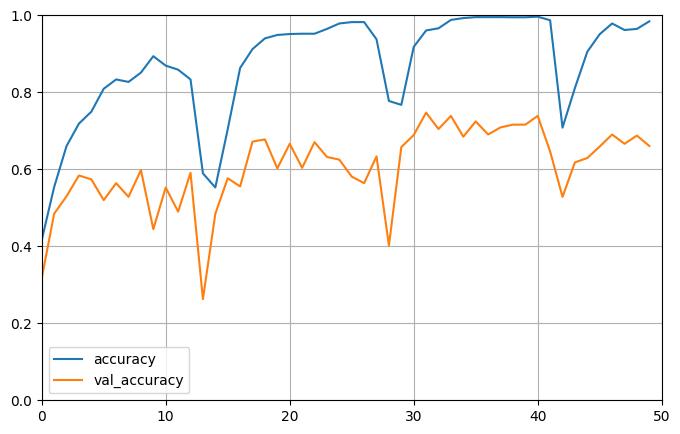

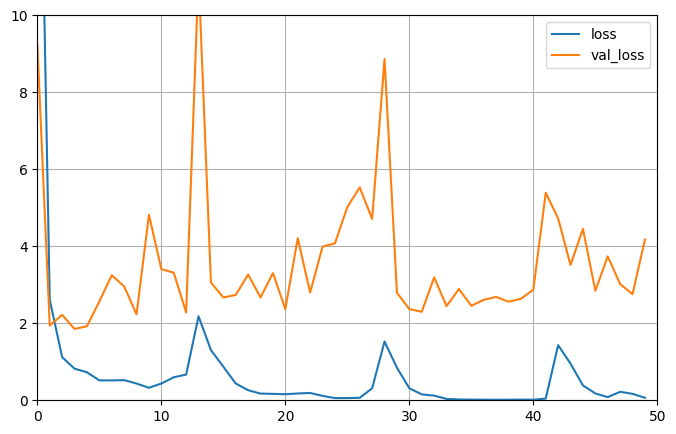

In [17]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
#因为accuracy的值和loss值的范围很不一样，因此我们打印两条曲线
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 10)


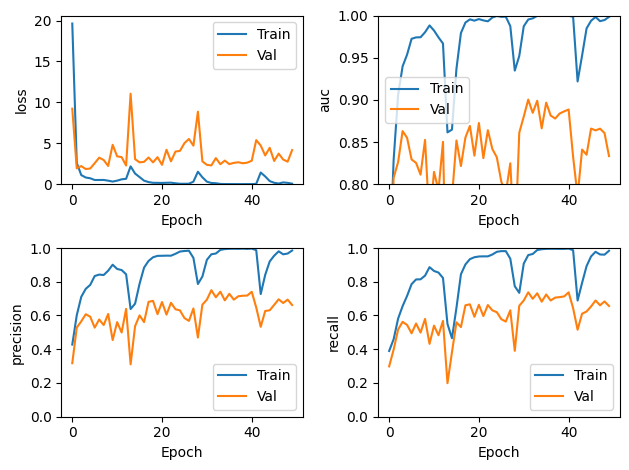

In [12]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric],label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()
plot_metrics(history)

In [13]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = valid_datagen.flow_from_directory(test_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
test_num = test_generator.samples

Found 120 images belonging to 6 classes.


In [14]:
def load_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255
    img_array = np.array(image, dtype=np.float32)
    image = np.expand_dims(img_array, axis=0)
    return image

def prediction_classes():
    dirs = os.listdir('./input/corn_leaf/test')
    print(dirs)
    for classes in dirs:
        classes_pathname = os.path.join('./input/corn_leaf/test',classes)
        count = 0
        for filepath, dirnames, filenames in os.walk(classes_pathname):
            for filename in filenames:
                filename_path = os.path.join(filepath, filename)
                img = load_preprocess_image(filename_path)
                prediction = model.predict(img)
                num=['dabanbing','healthy','huibanbing','wandaoyebanbing','xiubing','yuanbanbing']
                print ("This is a %s"%(num[int(np.argmax(prediction, axis=1))]))
                if classes == num[int(np.argmax(prediction, axis=1))]:
                    count+=1
            print(count)
            print('{}准确率为：{:.2f}%'.format(classes,count/20*100))


prediction_classes()


['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']
1/1 [==============================] - 0s 239ms/step
This is a dabanbing
1/1 [==============================] - 0s 14ms/step
This is a dabanbing
1/1 [==============================] - 0s 9ms/step
This is a wandaoyebanbing
1/1 [==============================] - 0s 26ms/step
This is a dabanbing
1/1 [==============================] - 0s 22ms/step
This is a dabanbing
1/1 [==============================] - 0s 15ms/step
This is a dabanbing
1/1 [==============================] - 0s 15ms/step
This is a yuanbanbing
1/1 [==============================] - 0s 17ms/step
This is a dabanbing
1/1 

In [15]:
count = 0
def Accuracy(predict_array,true_classes,count):
    num=['dabanbing','healthy','huibanbing','wanbaoyebanbing','xiubing','yuanbanbing']
    for j in predict_array:
        classes = num[int(np.argmax(j))]
        if classes == num[true_classes]:
            count += 1
    print('{}的准确率为：{}%'.format(num[true_classes],count/20*100))

test_predict = model.predict(test_generator)
# print(test_predict)
# print(test_predict.shape)
# print(type(test_predict))
predict_dabanbing = test_predict[:20]
Accuracy(predict_dabanbing,0,count)
predict_healthy = test_predict[20:40]
Accuracy(predict_healthy,1,count)
predict_huibanbing = test_predict[40:60]
Accuracy(predict_huibanbing,2,count)
predict_wanbaoyebanbing = test_predict[60:80]
Accuracy(predict_wanbaoyebanbing,3,count)
predict_xiubing = test_predict[80:100]
Accuracy(predict_xiubing,4,count)
predict_yuanbanbing = test_predict[100:120]
Accuracy(predict_yuanbanbing,5,count)

8/8 [==============================] - 3s 407ms/step
dabanbing的准确率为：90.0%
healthy的准确率为：30.0%
huibanbing的准确率为：60.0%
wanbaoyebanbing的准确率为：80.0%
xiubing的准确率为：85.0%
yuanbanbing的准确率为：25.0%


In [16]:
model.save('./saved_model/my_model3')

INFO:tensorflow:Assets written to: ./saved_model/my_model3\assets


INFO:tensorflow:Assets written to: ./saved_model/my_model3\assets
